# A/B-тестирование: влияние изменений интерфейса на поведение пользователей
Автор: **Александр Пионт**

Задача — сравнить две группы пользователей (контрольную и тестовую), определить статистическую и практическую значимость различий с помощью классических методов статистики.

## 1️) Импорт библиотек и генерация данных

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set(style='whitegrid', palette='pastel')
np.random.seed(42)

# Размер выборки
n = 5000

# Моделируем поведение пользователей: время на странице (сек)
control = np.random.normal(loc=60, scale=30, size=n)
variant = np.random.normal(loc=63, scale=32, size=n)

# Создаём DataFrame
df = pd.DataFrame({
    'group': ['Control']*n + ['Variant']*n,
    'time_on_page': np.concatenate([control, variant])
})

df.head()

,group,time_on_page
0,Control,74.901425
1,Control,55.852071
2,Control,79.430656
3,Control,105.690896
4,Control,52.975399


## 2️) Описательная статистика

In [2]:
df.groupby('group')['time_on_page'].describe().T

group,Control,Variant
count,5000.000000,5000.000000
mean,60.168058,62.684035
std,29.894395,32.333987
min,-37.238020,-62.516808
25%,40.262849,41.029347
50%,60.403968,62.441583
75%,79.980318,84.671618
max,177.787131,175.929766


## 3️) Визуализация распределений

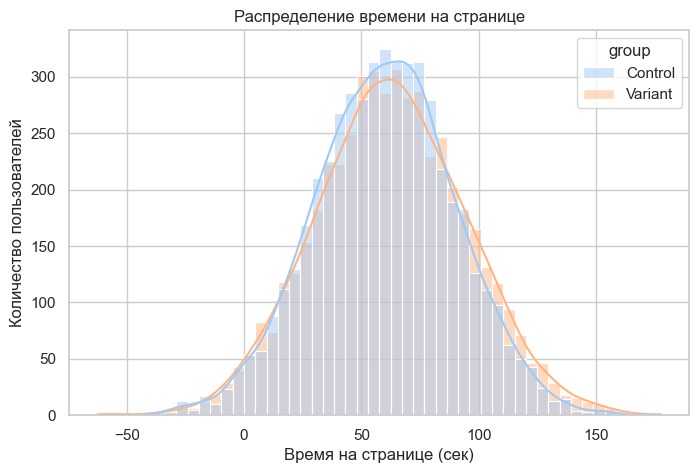

In [12]:
plt.figure(figsize=(8,5))
sns.histplot(df, x='time_on_page', hue='group', kde=True, bins=50, alpha=0.5)
plt.title('Распределение времени на странице')
plt.xlabel('Время на странице (сек)')
plt.ylabel('Количество пользователей')
plt.show()

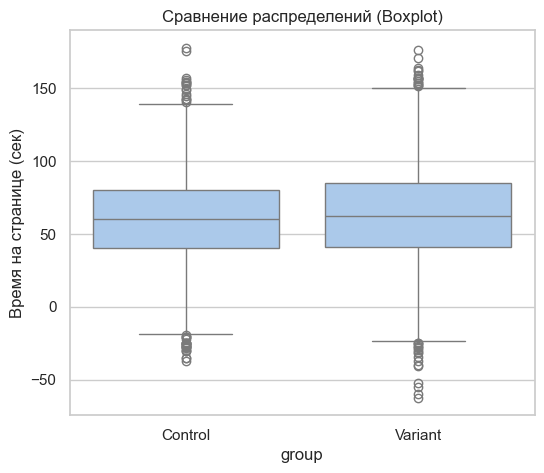

In [4]:
plt.figure(figsize=(6,5))
sns.boxplot(data=df, x='group', y='time_on_page')
plt.title('Сравнение распределений (Boxplot)')
plt.ylabel('Время на странице (сек)')
plt.show()

## 4️) Проверки предположений для t-теста

In [13]:
# Тест Левена — проверка равенства дисперсий
levene_res = stats.levene(df[df['group']=='Control']['time_on_page'],
                           df[df['group']=='Variant']['time_on_page'])

# Тест Шапиро — нормальность (на подвыборке)
sh_control = stats.shapiro(df[df['group']=='Control']['time_on_page'].sample(500))
sh_variant = stats.shapiro(df[df['group']=='Variant']['time_on_page'].sample(500))

levene_res, sh_control, sh_variant

(LeveneResult(statistic=np.float64(25.6268868888664), pvalue=np.float64(4.216053074717751e-07)),
 ShapiroResult(statistic=np.float64(0.9963553015920247), pvalue=np.float64(0.31210521195538893)),
 ShapiroResult(statistic=np.float64(0.9972576939784251), pvalue=np.float64(0.5768885297652485)))

## 5️) Проверка гипотез: t-test и Mann–Whitney

In [14]:
# t-test
t_res = stats.ttest_ind(df[df['group']=='Control']['time_on_page'],
                        df[df['group']=='Variant']['time_on_page'],
                        equal_var=False)

# Mann–Whitney
u_res = stats.mannwhitneyu(df[df['group']=='Control']['time_on_page'],
                            df[df['group']=='Variant']['time_on_page'],
                            alternative='two-sided')

t_res, u_res

(TtestResult(statistic=np.float64(-4.040031423419603), pvalue=np.float64(5.384631272648488e-05), df=np.float64(9937.096411502444)),
 MannwhitneyuResult(statistic=np.float64(11962610.0), pvalue=np.float64(0.0001969026558249537)))

## 6) Эффект размера (Cohen's d)

In [15]:
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx-1)*np.var(x, ddof=1) + (ny-1)*np.var(y, ddof=1)) / dof)
    return (np.mean(y) - np.mean(x)) / pooled_std

cohen_d = cohens_d(df[df['group']=='Control']['time_on_page'], df[df['group']=='Variant']['time_on_page'])
cohen_d

np.float64(0.08080062846839213)

## 7️) Дополнительно: проверка бинарной метрики (конверсия)
Допустим, что у пользователей была возможность совершить действие (например, клик). Посмотрим, отличается ли конверсия между группами.

In [16]:
# Смоделируем бинарные данные (1 — конверсия, 0 — нет)
conv_control = np.random.binomial(1, 0.10, n)
conv_variant = np.random.binomial(1, 0.115, n)

conv_df = pd.DataFrame({
    'group': ['Control']*n + ['Variant']*n,
    'converted': np.concatenate([conv_control, conv_variant])
})

conv_df.groupby('group')['converted'].mean()

group
Control    0.1072
Variant    0.1046
Name: converted, dtype: float64

### Z-test

In [17]:
p1 = conv_df[conv_df['group']=='Control']['converted'].mean()
p2 = conv_df[conv_df['group']=='Variant']['converted'].mean()
n1 = n2 = n
p_pool = (p1*n1 + p2*n2) / (n1 + n2)
se = np.sqrt(p_pool*(1-p_pool)*(1/n1 + 1/n2))
z = (p2 - p1) / se
p_value = 2*(1 - stats.norm.cdf(abs(z)))

{'z_stat': z, 'p_value': p_value}

{'z_stat': np.float64(-0.4224762745306358),
 'p_value': np.float64(0.672677414613577)}

## 8️) Итоговые результаты

In [18]:
results = {
    'Control mean (time)': round(df[df['group']=='Control']['time_on_page'].mean(),2),
    'Variant mean (time)': round(df[df['group']=='Variant']['time_on_page'].mean(),2),
    't-test p-value': round(t_res.pvalue, 4),
    'Mann–Whitney p-value': round(u_res.pvalue, 4),
    'Cohen d': round(cohen_d, 3),
    'Conversion Control': round(p1,4),
    'Conversion Variant': round(p2,4),
    'Z-test p-value': round(p_value, 4)
}
results

{'Control mean (time)': np.float64(60.17),
 'Variant mean (time)': np.float64(62.68),
 't-test p-value': np.float64(0.0001),
 'Mann–Whitney p-value': np.float64(0.0002),
 'Cohen d': np.float64(0.081),
 'Conversion Control': np.float64(0.1072),
 'Conversion Variant': np.float64(0.1046),
 'Z-test p-value': np.float64(0.6727)}

# Выводы
В ходе проекта были смоделированы данные для двух групп пользователей (контрольной и тестовой), рассчитаны описательные статистики и проведены проверки гипотез с помощью t-теста, U-теста Манна–Уитни и z-теста для бинарной метрики.

Полученные результаты показывают небольшие статистические различия между группами, однако данные были сгенерированы случайным образом, поэтому они не отражают реального поведения пользователей. Цель проекта — продемонстрировать понимание принципов A/B-тестирования, работы с данными и применения статистических методов на практике.